In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from homogeneous import HomogeneousArray, HomogeneousMatrix

In [18]:
IMAGE_FOLDER = "images/arcdetriomphe"

im1 = np.asarray(Image.open(f"{IMAGE_FOLDER}/img1.jpg"))
im2 = np.asarray(Image.open(f"{IMAGE_FOLDER}/img2.jpg"))

10


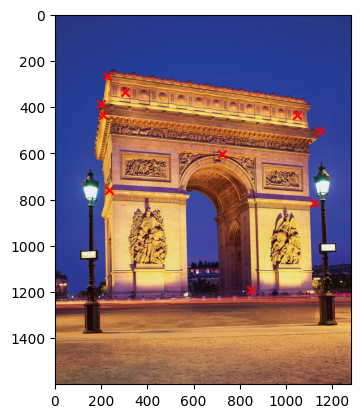

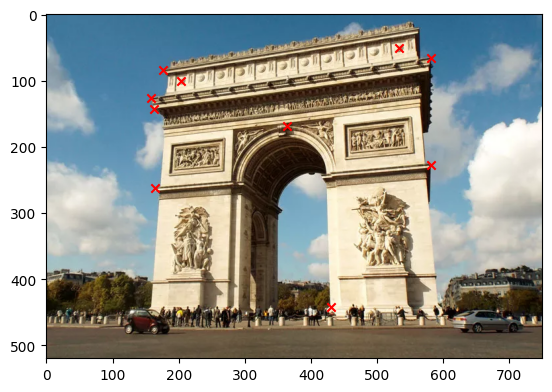

In [19]:
point_correspondences = np.load(f"{IMAGE_FOLDER}/pc.npy")

print(len(point_correspondences))

plt.imshow(im1)
for pt in point_correspondences:
    x = pt[0]
    plt.scatter(*x, c="red", marker="x")
plt.show()

plt.imshow(im2)
for pt in point_correspondences:
    x_ = pt[1]
    plt.scatter(*x_, c="red", marker="x")
plt.show()

In [20]:
xs = [HomogeneousArray(pt[0]) for pt in point_correspondences]
x_s = [HomogeneousArray(pt[1]) for pt in point_correspondences]

In [21]:
def right_null_vector(A):
    _, _, vh = np.linalg.svd(A)
    return vh[-1, :]

def get_fundamental_matrix(xs, x_s):
    A = []
    for (x, x_) in zip(xs, x_s):
        ur, vr = x.dh
        ul, vl = x_.dh

        A.append([ur * ul, ul * vr, ul, vl * ur, vl * vr, vl, ur, vr, 1])
    
    F = right_null_vector(A)
    return HomogeneousMatrix(F.reshape(3, 3))

F = get_fundamental_matrix(xs, x_s)

In [22]:
for i in range(len(xs)):
    assert np.isclose(x_s[i].T @ F @ xs[i], 0, atol=1), f'Epipolar constraint is not satisfied {x_s[i].T @ F @ xs[i]}'

print('Epipolar constraint is satisfied')

Epipolar constraint is satisfied


In [23]:
def get_epipole(F):
    e = right_null_vector(F)
    e_ = right_null_vector(F.T)
    return HomogeneousArray(e, homo=True), HomogeneousArray(e_, homo=True)

e, e_ = get_epipole(F)

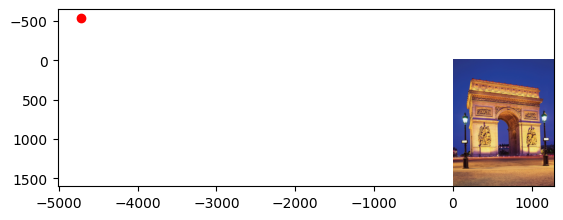

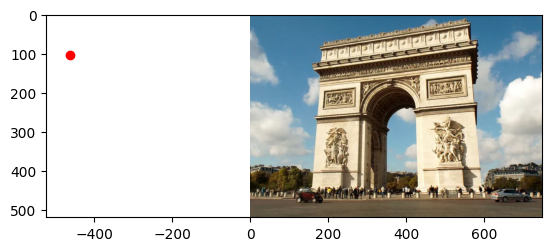

In [24]:
plt.imshow(im1)
plt.scatter(*e.dh, c='red')
plt.show()
plt.imshow(im2)
plt.scatter(*e_.dh, c='red')
plt.show()

In [25]:
assert np.all(np.isclose(e_.T @ F, 0, atol=1e-3))
assert np.all(np.isclose(F @ e, 0, atol=1e-3))
print('Epipoles are in null space of F')

Epipoles are in null space of F


In [26]:
def skew_symmetric(v):
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def get_camera_matrices(F):
    e, e_ = get_epipole(F)
    P = np.hstack([np.eye(3), HomogeneousArray([0, 0, 0], homo=True)])
    P = HomogeneousMatrix(P)
    e_skew = skew_symmetric(e_.T[0])
    P_ = np.hstack([e_skew @ F, e_.reshape(-1, 1)])
    P_ = HomogeneousMatrix(P_)
    return P, P_

P, P_ = get_camera_matrices(F)
C, C_ = right_null_vector(P), right_null_vector(P_)

assert np.all(np.isclose(P @ C, 0, 1e-10)), "Camera Center isn't right null vector"
assert np.all(np.isclose(P_ @ C_, 0, 1e-10)), "Camera Center isn't right null vector"
assert np.all(np.isclose(HomogeneousArray(P @ C_, homo=True).dh, e.dh, 1e-5)), "Projection of camera center != epipole"
assert np.all(np.isclose(HomogeneousArray(P_ @ C, homo=True).dh, e_.dh, 1e-5)), "Projection of camera center != epipole"

In [27]:
assert np.all(np.isclose(P_.T @ F @ P, 0, atol=1))
print('P_.T @ F @ P is skew symmetric')

P_.T @ F @ P is skew symmetric


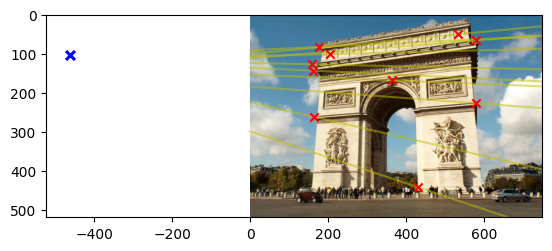

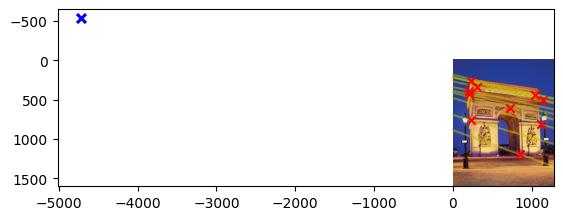

In [28]:
# Plot Epipolar Line

def get_epipolar_line(F, x, img, n_points=100):
    line = (F @ x).T.dh[0]
    xgrid = np.linspace(0, img.shape[1]-1, n_points)
    ygrid = - (line[0] * xgrid + line[2]) / line[1]
    xgrid = xgrid[np.logical_and(ygrid >= 0, ygrid < img.shape[0])]
    ygrid = ygrid[np.logical_and(ygrid >= 0, ygrid < img.shape[0])]
    return xgrid, ygrid

point_idx = 7

plt.imshow(im2, zorder=-2)
for point_idx in range(len(xs)):
    x, y = get_epipolar_line(F, xs[point_idx], im2)
    plt.plot(x, y, alpha=0.5, c='y', zorder=-1)
    plt.scatter(*x_s[point_idx].dh, c='red', marker='x', label="x'")
    plt.scatter(*e_.dh, c='blue', marker='x', label="e'")
plt.show()

plt.imshow(im1, zorder=-2)
for point_idx in range(len(x_s)):
    x, y = get_epipolar_line(F.T, x_s[point_idx], im1)
    plt.plot(x, y, alpha=0.5, c='y', zorder=-1)
    plt.scatter(*xs[point_idx].dh, c='red', marker='x', label="x'")
    plt.scatter(*e.dh, c='blue', marker='x', label="e'")
plt.show()

In [29]:
def apply_mat(mat, img):
    h, w = img.shape[:2]
    
    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    coords = np.stack([x.ravel(), y.ravel(), np.ones_like(x).ravel()], axis=0)  # (3, N)
    
    transformed_coords = mat @ coords
    transformed_coords /= transformed_coords[2, :]
    
    x_new, y_new = transformed_coords[:2]
    
    x_min, x_max = int(np.min(x_new)), int(np.max(x_new))
    y_min, y_max = int(np.min(y_new)), int(np.max(y_new))
    
    new_w, new_h = x_max - x_min + 1, y_max - y_min + 1
    output = np.ones((new_h, new_w, *img.shape[2:]), dtype=img.dtype) * 255
    
    x_new = (x_new - x_min).astype(int)
    y_new = (y_new - y_min).astype(int)
    
    valid_mask = (x_new >= 0) & (x_new < new_w) & (y_new >= 0) & (y_new < new_h)
    output[y_new[valid_mask], x_new[valid_mask]] = img[y.ravel()[valid_mask], x.ravel()[valid_mask]]
    
    return output, [x_min, x_max, y_max, y_min]


In [30]:
from scipy.optimize import minimize

def get_translation_mat(x):
    Tr = np.zeros((3, 3))
    Tr[:, -1] = -x.squeeze()
    np.fill_diagonal(Tr,  1)
    return Tr

def get_rotation_mat(e):
    R = np.eye(3)
    R[:2, :2] = np.array([[e[0], e[1]], [-e[1], e[0]]])[..., 0]
    return R

def bundle_adjustment(xs, x_s, F):
    x_hats = []
    x_hat_s = []

    for point_idx in range(len(xs)):
        # Translating
        Tr = get_translation_mat(xs[point_idx])
        Tr_ = get_translation_mat(x_s[point_idx])
        x = Tr @ xs[point_idx]
        x_ = Tr_ @ x_s[point_idx]
        tr_F = np.linalg.inv(Tr_.T) @ F @ np.linalg.inv(Tr)

        tr_e, tr_e_ = get_epipole(tr_F)

        tr_e /= np.linalg.norm(tr_e[:2])
        tr_e_ /= np.linalg.norm(tr_e_[:2])

        assert np.all(np.isclose(x_.T @ tr_F @ x, 0, atol=1)), "Doesn't satisfy loose epipolar constraint"

        # Rotation

        R = get_rotation_mat(tr_e)
        R_ = get_rotation_mat(tr_e_)

        r_e = R @ tr_e
        r_e_ = R_ @ tr_e_

        r_F = np.linalg.inv(R_.T) @ tr_F @ np.linalg.inv(R)

        assert np.all(np.isclose(r_e, np.array([[1], [0], tr_e[2]]))), f"Rotated epipole not on x-axis"
        assert np.all(np.isclose(r_e_, np.array([[1], [0], tr_e_[2]]))), "Rotated epipole not on x-axis"

        f = r_e[-1][0]
        f_ = r_e_[-1][0]

        def get_t_(t, a, b, c, d):
            return -(c*t+d)/(a*t + b)

        def unconstrained_objective(t, f, f_, a, b, c, d):
            t_ = get_t_(t, a, b, c, d)
            return t**2 / (1 + (f * t)**2) + t_**2 / (1 + (f_ * t_)**2)

        def get_x_hat(f, t):
            return HomogeneousArray([f*t**2 / (1 + (f*t)**2), t / (1 + (f*t)**2)])

        def solve_for_x_hat(f, f_, a, b, c, d):
            objective = lambda t: unconstrained_objective(t, f, f_, a, b, c, d)
            result = minimize(objective, x0=0)
            t = result.x[0]
            
            return get_x_hat(f, t), get_x_hat(f_, -(c*t+d)/(a*t + b))

        
        # ?
        a, b, c, d = r_F[1, 1], r_F[1, 2], r_F[2, 1], r_F[2, 2]

        x_hat, x_hat_ = solve_for_x_hat(f, f_, a, b, c, d)

        assert np.all(np.isclose(x_hat_.T @ r_F @ x_hat, 0, atol=1e-2)), "Doesn't satisfy hard epipolar constraint"

        x_hat = np.linalg.inv(Tr) @ np.linalg.inv(R) @ x_hat
        x_hat_ = np.linalg.inv(Tr_) @ np.linalg.inv(R_) @ x_hat_

        x_hat = HomogeneousArray(x_hat.T[0], homo=True)
        x_hat_ = HomogeneousArray(x_hat_.T[0], homo=True)

        assert np.all(np.isclose(x_hat_.T @ F @ x_hat, 0, atol=1e-2)), "Doesn't satisfy hard epipolar constraint (untransformed)"
        
        x_hats.append(x_hat)
        x_hat_s.append(x_hat_)

    return x_hats, x_hat_s


x_hats, x_hat_s = bundle_adjustment(xs, x_s, F)
        

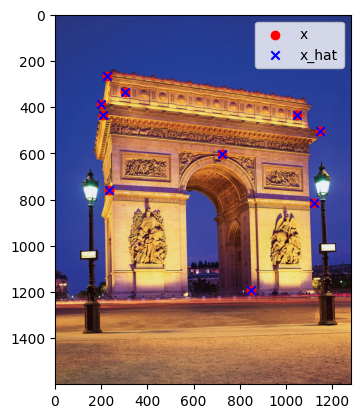

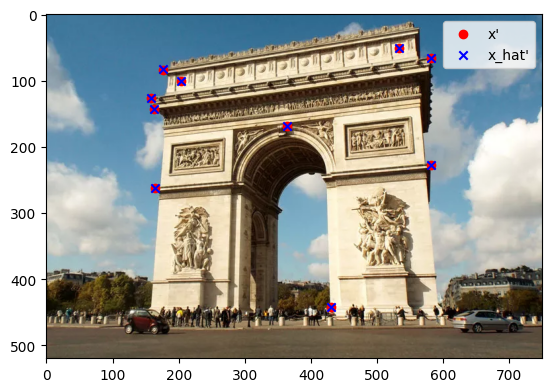

In [31]:
# Adjustments

plt.imshow(im1)
plt.scatter(*zip(*[x.dh for x in xs]), c='red', label='x')
plt.scatter(*zip(*[x_hat.dh for x_hat in x_hats]), c='blue', marker='x', label='x_hat')
plt.legend()
plt.show()

plt.imshow(im2)
plt.scatter(*zip(*[x_.dh for x_ in x_s]), c='red', label="x'")
plt.scatter(*zip(*[x_hat_.dh for x_hat_ in x_hat_s]), c='blue', marker="x", label="x_hat'")
plt.legend()
plt.show()

In [32]:
def triangulate_point(x, x_prime, P, P_prime):
    A = np.array([
        x[0] * P[2, :] - P[0, :],
        x[1] * P[2, :] - P[1, :],
        x_prime[0] * P_prime[2, :] - P_prime[0, :],
        x_prime[1] * P_prime[2, :] - P_prime[1, :]
    ])
    
    X = right_null_vector(A)
    
    return HomogeneousArray(X, homo=True)

In [33]:
points_3d = []
for i in range(len(x_hats)):
    p1 = triangulate_point(x_hats[i], x_hat_s[i], P, P_)
    points_3d.append(p1.dh)

points_3d = np.array(points_3d)

In [34]:
def bilinear_interpolate(im, x, y):
        x0 = int(np.floor(x))
        x1 = x0 + 1
        y0 = int(np.floor(y))
        y1 = y0 + 1

        if x0 < 0 or x1 >= im.shape[1] or y0 < 0 or y1 >= im.shape[0]:
            return np.array([0, 0, 0])

        Ia = im[y0, x0]
        Ib = im[y1, x0]
        Ic = im[y0, x1]
        Id = im[y1, x1]

        wa = (x1 - x) * (y1 - y)
        wb = (x1 - x) * (y - y0)
        wc = (x - x0) * (y1 - y)
        wd = (x - x0) * (y - y0)

        return wa * Ia + wb * Ib + wc * Ic + wd * Id

def get_colours(points_3d, img, P):
    colours = []
    for pt in points_3d:
        pixel_coord = HomogeneousArray((P @ HomogeneousArray(pt)).T[0], homo=True).dh
        colour = bilinear_interpolate(img, *pixel_coord)
        colours.append(colour / 255)
    
    return colours

colours = get_colours(points_3d, im2, P_)

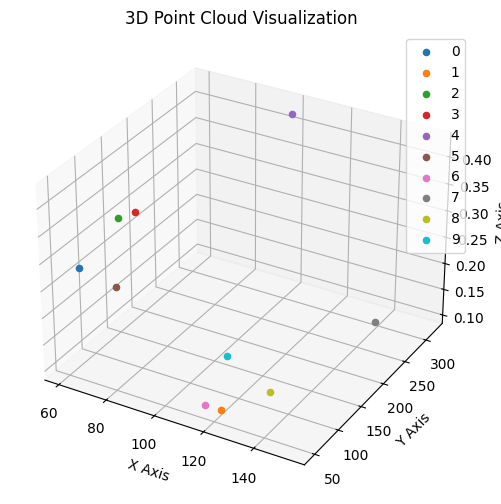

In [51]:
X, Y, Z = points_3d[:, 0], points_3d[:, 1], points_3d[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

for i, (x, y, z) in enumerate(zip(X, Y, Z)):
    ax.scatter(x, y, z, marker='o', label=f"{i}")

# ax.scatter3D(X, Y, X, marker='o', c=colours)

# Labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title("3D Point Cloud Visualization")

plt.legend()
plt.show()

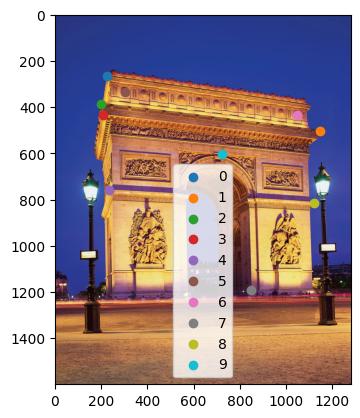

In [47]:
plt.imshow(im1)

for i, x in enumerate(xs):
    plt.scatter(*x.dh, label=f"{i}")

plt.legend()

In [53]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
pcd.colors = o3d.utility.Vector3dVector(colours)

o3d.visualization.draw_geometries([pcd])